In [1]:
# Import Libraries 
import numpy as np 
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#loading rating dataset
ratings = pd.read_csv("/your_path/csv_files/ratings.csv")
print(ratings.head())


   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [ ]:
# loading movie dataset
movies = pd.read_csv("/your_path/csv_files/movies.csv") 
print(movies.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [4]:
n_ratings = len(ratings)
n_movies = len(ratings['movieId'].unique()) 
n_users = len(ratings['userId'].unique())

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}") 
print(f"Number of unique users: {n_users}")
print(f"Average ratings per user: {round(n_ratings/n_users, 2)}") 
print(f"Average ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average ratings per user: 165.3
Average ratings per movie: 10.37


In [5]:
user_freq = ratings[['userId', 'movieId']].groupby( 'userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings'] 
print(user_freq.head())

   userId  n_ratings
0       1        232
1       2         29
2       3         39
3       4        216
4       5         44


In [6]:
# Create user-item matrix using CSR format
def create_matrix(df):
    N = len(df['userId'].unique()) # Number of users
    M = len(df['movieId'].unique()) # Number of movies
    # Map IDs to indices
    user_mapper = {user_id: idx for idx, user_id in enumerate(df['userId'].unique())}
    movie_mapper = {movie_id: idx for idx, movie_id in enumerate(df['movieId'].unique())}
    # Create indices for matrix
    user_index = df['userId'].map(user_mapper)
    movie_index = df['movieId'].map(movie_mapper)
    X = csr_matrix((df['rating'],(movie_index, user_index)),shape=(M, N))
    return X, user_mapper, movie_mapper

In [7]:
# Find similar movies using KNN
def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k=10,metric='cosine'):
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec.reshape(1, -1))
    neighbour_ids = [movie_inv_mapper[n] for n in
    neighbour[1].flatten()][1:] # Exclude the movie itself
    return neighbour_ids

In [8]:
def recommend_movies_for_user(user_id, X, user_mapper, movie_mapper,
    movie_inv_mapper, ratings, k=10):
    user_ratings = ratings[ratings['userId'] == user_id]
    if user_ratings.empty:
        print(f"User with ID {user_id} does not exist.")
        return
        
    movie_id = user_ratings.loc[user_ratings['rating'].idxmax(),'movieId'] # Movie with highest rating
    similar_ids = find_similar_movies(movie_id, X, movie_mapper,
    movie_inv_mapper, k)
    print(f"Since you watched {movies[movies['movieId'] == movie_id]['title'].iloc[0]}, you might also like:")
    for movie_id in similar_ids:
        print(movies[movies['movieId'] == movie_id]['title'].iloc[0])

In [9]:
# Create the user-item matrix
X, user_mapper, movie_mapper = create_matrix(ratings)
# Inverse mapper for movie IDs
movie_inv_mapper = {idx: movie_id for movie_id, idx in movie_mapper.items()}
# Example: Recommend movies for a user
user_id = 81 # Replace with the desired user ID
recommend_movies_for_user(user_id, X, user_mapper, movie_mapper,movie_inv_mapper, ratings, k=10)

Since you watched Twelve Monkeys (a.k.a. 12 Monkeys) (1995), you might also like:
Pulp Fiction (1994)
Terminator 2: Judgment Day (1991)
Independence Day (a.k.a. ID4) (1996)
Seven (a.k.a. Se7en) (1995)
Fargo (1996)
Fugitive, The (1993)
Usual Suspects, The (1995)
Jurassic Park (1993)
Star Wars: Episode IV - A New Hope (1977)
Heat (1995)


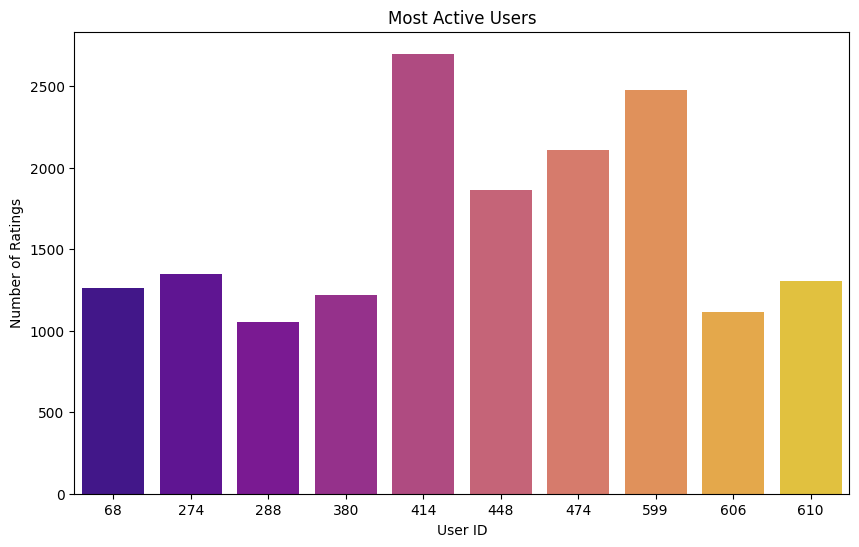

In [10]:
# Get the count of ratings for each user
user_ratings_count = ratings.groupby('userId').size().sort_values(ascending=False).head(10)
# Create the bar plot for most active users
plt.figure(figsize=(10, 6))
sns.barplot(x=user_ratings_count.index, y=user_ratings_count.values, palette='plasma')
plt.title("Most Active Users")
plt.xlabel("User ID")
plt.ylabel("Number of Ratings")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


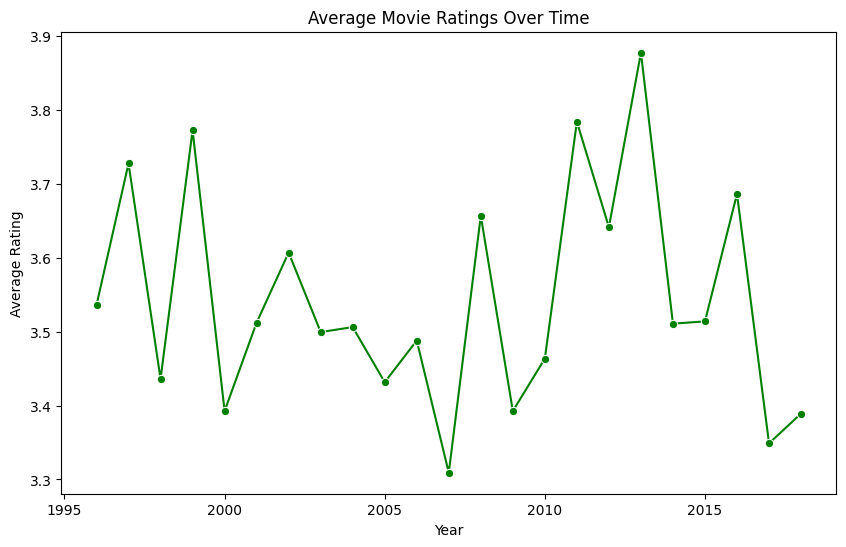

In [11]:
# Convert timestamp to datetime
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
# Extract the year from the timestamp
ratings['year'] = ratings['timestamp'].dt.year
# Calculate average ratings by year
avg_ratings_by_year = ratings.groupby('year')['rating'].mean()
# Create the line plot for rating trends over time
plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_ratings_by_year.index, y=avg_ratings_by_year.values, color='green', marker='o')
plt.title("Average Movie Ratings Over Time")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.show()